# Predictor Evaluation and Visualization

In [1]:
import os
os.chdir('/app/Pogona_realtime/Arena')

## Imports

In [22]:
import numpy as np
import pandas as pd
import pickle
import imp
import json
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.widgets import Slider, Button
import seaborn as sns
#from tqdm.auto import tqdm
from tqdm import tqdm
import torch
import glob
from datetime import datetime
import cv2 as cv
from scipy.stats import pearsonr


from Prediction import dataset
from Prediction import train_eval
from Prediction import predictor
from Prediction import visualize
from Prediction import detector
from Prediction import kalman_predict
from Prediction import seq2seq_predict
from Prediction import calibration as calib
from Prediction import traj_models

In [128]:
imp.reload(dataset)
imp.reload(train_eval)
imp.reload(seq2seq_predict)
imp.reload(predictor)
imp.reload(visualize)
imp.reload(detector)
imp.reload(dataset)
imp.reload(kalman_predict)

<module 'Prediction.kalman_predict' from '/app/Pogona_realtime/Arena/Prediction/kalman_predict.py'>

## Load data

In [3]:
all_df = dataset.collect_data(data_sources={'detections': True, 'timestamps': True, 'dlc': False, 'touches': True})

110 trials loaded


In [4]:
trials = all_df.index.unique()

## Load Trajectory Predictor and Hit Predictor

### Predictor parameters

In [5]:
input_labels = ['x1', 'y1', 'x2', 'y2']
output_labels = ['x1', 'y1', 'x2', 'y2']
net_params = {
    'input_labels': input_labels,
    'output_labels': output_labels,
    'input_dim': len(input_labels),
    'output_dim': len(output_labels),
    'inp_seq_len': 20,
    'out_seq_len': 20,
    'embedding_size': None,  # only used in supporting models.
    'hidden_size': 350,
    'rnn_layers': 1,
    'dropout': 0.05,
}


In [6]:
# Kalman Trajectory Predictor
traj_predictor = kalman_predict.KalmanPredictor(forecast_horizon=20, 
                                                num_derivatives=1, 
                                                q_var=2.145, r_var=120.0)

In [7]:
model_path_lstm = 'Prediction/traj_models/LSTMdense_1004-1803_i20_o20_h350_l1_40_best.pth'

model_type = 'LSTMdense'
net_lstm = seq2seq_predict.LSTMdense(net_params['out_seq_len'], 
                                hidden_size=net_params['hidden_size'], 
                                embedding_size=net_params['embedding_size'], 
                                LSTM_layers=net_params['rnn_layers'], 
                                dropout=net_params['dropout'])

/home/user/miniconda/envs/py37/lib/python3.7/site-packages/torch/nn/modules/rnn.py:60: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.05 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [8]:
#model_path = 'Prediction/traj_models/GRUEncDec_1004-2056_i20_o20_h350_l1_wl_best.pth'
#model_path_gru = 'Prediction/traj_models/GRUEncDecSched_1004-2307_i20_o20_h350_l1_best.pth'
#model_path = 'Prediction/traj_models/GRUEncDecSched_1004-2307_i20_o20_h350_l1_final.pth'
#model_path = 'Prediction/traj_models/GRUEncDecSched_1004-2325_i20_o20_h512_l1_best.pth'
#model_path = 'Prediction/traj_models/GRUEncDec_1005-1509_i20_o20_h350_l1_final.pth'
#model_path = 'Prediction/traj_models/GRUEncDec_1005-1735_i20_o20_h350_l1_extreme_mask_final.pth'
#model_path = 'Prediction/traj_models/GRUEncDec_1005-1735_i20_o20_h350_l1_extreme_mask_best.pth'
#model_path = 'Prediction/traj_models/GRUEncDec_1005-1105_i20_o10_h350_l1_best.pth'
#model_path_gru = 'Prediction/traj_models/GRUEncDec_1005-1938_i20_o20_h350_l1_extreme_mask2_best.pth'
#model_path_gru = 'Prediction/traj_models/GRUEncDec_1005-1509_i20_o20_h350_l1_final.pth'
#model_path_gru = 'Prediction/traj_models/GRUEncDecSched_1007-1914_i20_o20_h350_l1_high_mask_sched_best.pth'
model_path_gru = 'Prediction/traj_models/GRUEncDecSched_1007-1950_i20_o20_h350_l1_z1.2_sched_best.pth'

model_type = 'GRUEncDec'
net_gru = seq2seq_predict.GRUEncDec(output_seq_size=net_params['out_seq_len'], 
                                hidden_size=net_params['hidden_size'],
                                GRU_layers=net_params['rnn_layers'],
                                tie_enc_dec=False, use_gru_cell=True, 
                                dropout=net_params['dropout'])

In [9]:
# Seq2Seq Trajectory Predictor
traj_predictor_kalman = kalman_predict.KalmanPredictor(forecast_horizon=20, 
                                                num_derivatives=1, 
                                                q_var=2.145, r_var=120.0)
#traj_predictor_lstm = seq2seq_predict.Seq2SeqPredictor(net_lstm, model_path_lstm, net_params['inp_seq_len'], net_params['out_seq_len'])
traj_predictor_gru = seq2seq_predict.Seq2SeqPredictor(net_gru, model_path_gru, net_params['inp_seq_len'], net_params['out_seq_len'])

In [10]:
hit_predictor = predictor.HitPredictor(traj_predictor_gru, detector=None)

### Masking

In [11]:
def rad(deg):
    return deg*(np.pi/180) 

In [12]:
INF_P = 9999999

mask_dict = {
    'fl_dist': [0, INF_P, True, True], # min, max, mask_X, mask_Y
    'speed': [8, INF_P, True, True],
    'std': [0.0, INF_P, [0,1]],
    'corr': [0.0, 1.0, True, True],
    'zgzg': [0, 1.5, True, True],
    'keep_prob': 0.0
}

mask_fn = train_eval.compose_masks(mask_fns=[
    train_eval.mask_fl_dist(*mask_dict['fl_dist']),
    train_eval.mask_speed(*mask_dict['speed']),
    train_eval.mask_std(*mask_dict['std']),
    train_eval.mask_corr(*mask_dict['corr']),
    train_eval.mask_zgzg(*mask_dict['zgzg'])
    ], invert=False)

### Draw sequences function

In [20]:
def draw_sequences(arr_X,
                   arr_Y,
                   arr_pred,
                   ax,
                   to_scatter=True,
                   l_alpha=0.35,
                   sctr_s=0.5,
                   sctr_alpha=1,
                   past_c='b', ftr_c='r', pred_c='g', diff_c='k',
                   xlabel = 'past',
                   ylabel = 'future',
                   draw_diffs=True):
    
    
    if arr_X is not None:
        if len(arr_X.shape)==2:
            arr_X = arr_X.reshape(1,arr_X.shape[0],arr_X.shape[1])
    if arr_Y is not None:
        if len(arr_Y.shape)==2:
            arr_Y = arr_Y.reshape(1,arr_Y.shape[0],arr_Y.shape[1])
    if draw_diffs:
        if len(arr_pred.shape)==2:
            arr_pred = arr_pred.reshape(1,arr_pred.shape[0],arr_pred.shape[1])
    
    if arr_X is not None:
        ax.add_collection(LineCollection(segments=[seq for seq in arr_X[:,:,:2]], colors=[past_c], label=xlabel,alpha=l_alpha))
    if arr_Y is not None:
        ax.add_collection(LineCollection(segments=[seq for seq in arr_Y[:,:,:2]], colors=[ftr_c], label=ylabel,alpha=l_alpha))
    if draw_diffs:
        ax.add_collection(LineCollection(segments=[seq for seq in arr_pred[:,:,:2]], colors=[pred_c],label='pred',alpha=l_alpha))
        diffs = [np.array([arr_pred[j,i,:2],arr_Y[j,i,:2]]) for i in range(arr_pred.shape[1]) for j in range(arr_pred.shape[0])]
        ax.add_collection(LineCollection(segments=diffs, colors=[diff_c],label='diff',alpha=l_alpha))
    if to_scatter:
        if arr_X is not None:
            ax.scatter(arr_X[:,:,0], arr_X[:,:,1], s=sctr_s, color=past_c, alpha=sctr_alpha)
        if arr_Y is not None:
            ax.scatter(arr_Y[:,:,0], arr_Y[:,:,1], s=sctr_s, color=ftr_c, alpha=sctr_alpha)
        if draw_diffs:
            ax.scatter(arr_pred[:,:,0], arr_pred[:,:,1], s=sctr_s, color=pred_c, alpha=sctr_alpha)



### Produce video

In [151]:
trial = 'learning_20200917T154539_trial3'
homography = dataset.homography_for_trial(trial)
correction_fn = visualize.get_correction_fn(homography,1920)
vid_path = dataset.get_trial_video_path(trial)
bboxes = all_df.loc[trial][['x1', 'y1', 'x2', 'y2']].values

In [159]:
out_path = f'../labelled/{trial}_check.mp4'
visualize.process_video(video_path=vid_path,
                        output_path=out_path,
                        process_fns=[visualize.offline_bbox_visualizer(bboxes, window_size=1)],
                        correction_fn = correction_fn,
                        #num_frames=500,
                        resize_to_width=960)

100%|██████████| 2977/2977 [01:21<00:00, 36.34it/s]


## Video sequence widget

In [13]:
#trial = trials[0]
trial = 'fast_cockroach_20200803T085738_trial1'
trial_df = all_df.loc[trial]
vid_path = dataset.get_trial_video_path(trial)
homography = dataset.homography_for_trial(trial)
correction_fn = visualize.get_correction_fn(homography, 1920)
trial

'fast_cockroach_20200803T085738_trial1'

In [14]:
val_trials

NameError: name 'val_trials' is not defined

In [15]:
X_trial, Y_trial = train_eval.trial_to_samples(trial_df,
                                               net_params['input_labels'], net_params['output_labels'], 
                                               net_params['inp_seq_len'], net_params['out_seq_len'], 
                                               keep_nans=True)

#X_trial, Y_trial = X_trial.numpy(), Y_trial.numpy()

In [16]:
def get_vid_frames(vid_path, start, num, correction_fn=None):
    vcap = cv.VideoCapture(vid_path)
    vcap.set(cv.CAP_PROP_POS_FRAMES, start)
    frames = []
    for i in range(num):
        ret, frame = vcap.read()
        if correction_fn:
            frame = correction_fn(frame)
        frames.append(frame)
        
    return frames

In [17]:
trial_mask = mask_fn(X_trial, Y_trial)
passed_mask = trial_mask.sum()
print(f'{passed_mask} masked out of {X_trial.shape[0]}')

98 masked out of 5042


In [18]:
def seq4_to_middle(seq_data):
    squeeze = False
    if len(seq_data.shape) == 2:
        squeeze = True
        seq_data = seq_data[None, :, :]
    
    # get (batch, seq, 4), xyxy, return (batch, seq, 2) xy, where x (x1+x2)/2
    X1, Y1, X2, Y2 = 0, 1, 2, 3
    ret = np.stack([(seq_data[:,:,X1] + seq_data[:,:,X2])/2, seq_data[:,:,Y2]], axis=2)
    if squeeze:
        return ret.squeeze()
    return ret
    

In [490]:
X_x1y2

array([[869.51444588, 184.08470376],
       [870.11894514, 174.77115829],
       [871.29359239, 181.04663641],
       [871.72086996, 181.95721562],
       [874.08590162, 177.79633321],
       [873.71310247, 179.12505127],
       [876.39510265, 179.05674795],
       [878.73177248, 176.70962053],
       [882.01277853, 172.42438173],
       [889.67631174, 172.46445034],
       [909.78288072, 181.54433561],
       [918.46415907, 182.95965281],
       [927.98245801, 178.78928686],
       [935.22107766, 179.37727388],
       [940.18026603, 177.27765186],
       [940.26050494, 178.18795021],
       [942.35379448, 177.75443285],
       [944.03819049, 175.30725155],
       [947.5473625 , 177.13866057],
       [952.45230703, 174.95728649]])

In [502]:
np.concatenate([X_x1y2,Y_x1y2])[5]

array([873.71310247, 179.12505127])

In [21]:
%matplotlib widget

X1, Y1, X2, Y2 = 0, 1, 2, 3

# choose random sequnce
if not np.any(trial_mask):
    raise Exception('Data mask is all False')
seq_num = np.random.choice(np.argwhere(trial_mask).squeeze())

total_timesteps = net_params['inp_seq_len'] + net_params['out_seq_len']

seq = seq4_to_middle(X_trial[seq_num]), seq4_to_middle(Y_trial[seq_num])
alpha = 1/(total_timesteps)
cat_seq = np.concatenate(seq)
frames = get_vid_frames(vid_path, seq_num, total_timesteps, correction_fn)

fig, ax = plt.subplots(1, 1, figsize=(8,13))
plt.subplots_adjust(left=0.25, bottom=0.1)
fig.suptitle(f"Trial: {trial} sequence num: {seq_num}\n masked: {trial_mask.sum()}")

ax_im = ax.imshow(frames[0])
#draw_sequences(X_trial[seq_num][:,X2:], Y_trial[seq_num][:,X2:], None, ax, draw_diffs=False)
#draw_sequences(seq4_to_middle(X_trial[seq_num]), seq4_to_middle(Y_trial[seq_num]), None, ax, draw_diffs=False)
X_x1y2 = X_trial[seq_num][:,[X1,Y2]]
Y_x1y2 = Y_trial[seq_num][:,[X1,Y2]]

X_x2y2 = X_trial[seq_num][:,X2:]
Y_x2y2 = Y_trial[seq_num][:,X2:]
draw_sequences(X_x1y2, Y_x1y2 , None, ax, draw_diffs=False)
draw_sequences(X_x2y2, Y_x2y2 , None, ax, draw_diffs=False)


ls = [np.array([np.concatenate([X_x1y2,Y_x1y2])[i], np.concatenate([X_x2y2,Y_x2y2])[i]]) for i in range(total_timesteps)]
ax.add_collection(LineCollection(segments=ls, colors=['y'],alpha=0.5, zorder=1))
curr = ax.add_collection(LineCollection(segments=[ls[0]], colors=['g'],alpha=0.5, zorder=2))


#ax_cur_point = ax.scatter(seq[0][0, X2], seq[0][0, Y2], c='g')
#ax_cur_point = ax.scatter(seq[0][0, 0], seq[0][0, 1], c='g')


slider_ax = plt.axes([0.25, 0.1, 0.65, 0.03], facecolor='lightgoldenrodyellow')
slider = Slider(slider_ax, "timestep", 0, total_timesteps, valinit=0, valstep=1)


def update_timestep(t):
    t = int(t)
    ax_im.set_data(frames[t])
    if t >= net_params['inp_seq_len']:
        idx = t - net_params['inp_seq_len']
        #ax_cur_point.set_offsets([seq[1][idx, X2], seq[1][idx, Y2]])
        #ax_cur_point.set_offsets([seq[1][idx, 0], seq[1][idx, 1]])
    else:
        pass
        #ax_cur_point.set_offsets([seq[0][t, X2], seq[0][t, Y2]])
        #ax_cur_point.set_offsets([seq[0][t, 0], seq[0][t, 1]])
    
    
    fig.canvas.draw_idle()
fig.set_facecolor(color='w')
slider.on_changed(update_timestep)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

0

## Timing distributions

In [53]:
eval_results_kalman = eval_results
kalman_times = np.array(eval_results_kalman['times'])

In [54]:
eval_results['avg time (ms)']

0.18052204554767454

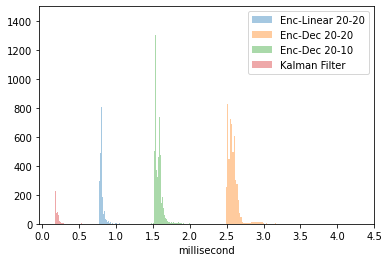

In [80]:
sns.distplot(lstm_times[lstm_times < 0.005]*1000, bins=100, kde=False, label='Enc-Linear 20-20')
sns.distplot(gru20_times[gru20_times < 0.005]*1000, bins=100, kde=False, label='Enc-Dec 20-20')
sns.distplot(gru10_times[gru10_times < 0.005]*1000, bins=100, kde=False, label='Enc-Dec 20-10')
sns.distplot(kalman_times[kalman_times < 0.005]*1000, bins=100, kde=False, label='Kalman Filter')
plt.legend()
plt.xticks(np.arange(0, 5, 0.5))
plt.xlabel('millisecond')
plt.ylim((0, 1500))
plt.savefig('../experiments_plots/all_timings.png', dpi=200)

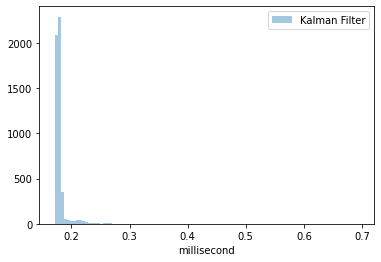

In [70]:
sns.distplot(kalman_times[kalman_times < 0.001]*1000, bins=100, kde=False, label='Kalman Filter')
plt.legend()
plt.xlabel('millisecond')
plt.savefig('../experiments_plots/kalman_timings.png', dpi=200)

## Evaluate Hit Predictor

#### Hit predictor notes
Hit Prediction Evalutaion:<br>
For a trial with hit events, need to implement a function that outputs a structure that 
saves for each frame with a hit event, the forecasts that predicted a hit that occurs in that frame,
and the x values of every such prediction. The rationale for saving all of the forecasts that predicted a hit in a certain frame
is the that good predictions will ideally converge over consecutive forecasts.

Structure:<br>
For each frame in the video, create an array with dimensions forecast_horizon X 2 
(maybe just a 3d array, something like in predictions_per_step, and also save the x values)
Other idea - 2d array, (num_frames) X (forecast_horizon)

Functions:<br>
Iterate over forecasts which are not None, and threshold y2 values against y=0 in the arena (or some other y value).
If a bbox crosses the threshold for some forecast, save the index of the first crossing in the forecast, as a value in the relevant index of the frame.
For example, if the forecast_horizon is 20, and forecast 1000 (started from frame 1000) predicts a hit in it's 10 timestamp,
save the x value in index 10 in frame 1010. If forecast 1001 predicts an hit in it's 9th timestamp, save the value in index 9 in fram 1010.
Notice: for each frame, there are 20 indices: index 0 means that a forecast predicted a hit one frame in advance, index 8 means 12 frames in advance.

frame | forecast_0 | forecast_1 | ... | forecast_19
____________________________________________________
    0 | nan        |   x_1      | ... |    x_19    
    1 | x_0        |   x_1      | ... |    nan
    ....

from this, maybe a smaller array with columns "frame | num_forecasts_predicted_hit | mean_x_value"

Visualization:<br>
A horizontal indexed heatmap, where each timestamp is colored by the amount of forecasts that predict a hit
in that frame. On the same figure, plot with other colors the real hit events. 
It's a sort of a "raster plot".
Matplotlib function: "eventplot"
Also possible to generate a raster plot for each forecast seperatly - idealy, a hit event should be preceeded by a diagonal
pattern of predicted hits

TODO<br>
Maybe other visualiztions that combine the temporal data with the arena coordinates data.

Metrics - TODO:<br>
We can compare that structure to the real frames that have an actual hit event and their respective x values,
and calculate various metrics that quantify the errors. Join the the arrays.
FN - missed an hit event (by how much?)
FP - predicted an hit event by mistake (relative to what ground truth events?)
Other issues: how to decide what is a "close" event? what to do if there are many? etc...


In [264]:
hit_trials = ['learning_20200917T152238_trial1', 'fast_cockroach_20200803T085738_trial1',
             'learning_20201001T084647_trial1', 'fast_line_20200803T082414_trial1', 'line_20200803T081429_trial1']
hit_df = all_df.loc[hit_trials]

In [268]:
hit_df[hit_df.is_hit]

,cent_x,cent_y,x1,y1,x2,y2,conf,num_bbox,frame_ts,hit_x,hit_y,bug_x,bug_y,is_hit,touch_ts,is_touch
learning_20200917T152238_trial1,1422.422500,198.078546,1546.095343,373.313708,1303.232575,22.101105,0.991156,1.0,2020-09-17 15:22:44.916004181,1231.0,353.0,1219.0,364.0,True,2020-09-17 18:22:46.950596,True
fast_cockroach_20200803T085738_trial1,537.412451,186.044481,686.372198,346.104473,383.653352,16.392198,0.995390,1.0,2020-08-03 08:57:40.772247791,803.0,707.0,767.0,854.0,True,2020-08-03 08:57:40.774695,True
fast_cockroach_20200803T085738_trial1,381.192635,173.105245,526.147738,344.377689,228.107824,-7.294703,0.996411,1.0,2020-08-03 08:57:54.911134243,623.0,270.0,690.0,327.0,True,2020-08-03 08:57:54.906121,True
fast_cockroach_20200803T085738_trial1,975.434361,129.592947,1136.684996,286.517720,811.063974,-32.565122,0.998260,1.0,2020-08-03 08:58:12.750075340,1227.0,108.0,1147.0,28.0,True,2020-08-03 08:58:12.757401,True
fast_cockroach_20200803T085738_trial1,828.432762,117.951186,987.836035,268.404430,664.579663,-41.671382,0.998355,1.0,2020-08-03 08:58:13.497253656,1112.0,25.0,1012.0,-107.0,True,2020-08-03 08:58:13.503302,True
fast_cockroach_20200803T085738_trial1,1119.914205,165.570570,1276.209167,332.599437,962.948457,-7.988999,0.996518,1.0,2020-08-03 08:58:37.979384899,1434.0,627.0,1515.0,580.0,True,2020-08-03 08:58:37.976633,True
learning_20201001T084647_trial1,-45.495505,85.993298,86.709724,217.194621,-183.139383,-51.297857,0.995607,1.0,2020-10-01 08:47:03.844775438,74.0,332.0,57.0,292.0,True,2020-10-01 11:47:05.880701,True
fast_line_20200803T082414_trial1,-189.002461,1285.678913,-40.956125,1417.212515,-340.842964,1148.696265,0.996272,1.0,2020-08-03 08:24:15.613847494,2028.0,134.0,908.0,570.0,True,2020-08-03 08:24:15.603710,True
fast_line_20200803T082414_trial1,600.031768,126.729824,761.573715,274.951129,436.457676,-28.702548,0.996892,1.0,2020-08-03 08:24:42.118518114,804.0,211.0,766.0,252.0,True,2020-08-03 08:24:42.117620,True
line_20200803T081429_trial1,98.241666,205.037129,210.448093,340.806890,-16.767964,65.175833,0.980696,1.0,2020-08-03 08:14:43.849375963,113.0,691.0,49.0,795.0,True,2020-08-03 08:14:43.845381,True


In [12]:
lots_o_touches = 'circle_20200803T115839_trial1'
lots_o_touches2 = 'fast_cockroach_20200803T085738_trial1'

In [272]:
hit_trials

['learning_20200917T152238_trial1',
 'fast_cockroach_20200803T085738_trial1',
 'learning_20201001T084647_trial1',
 'fast_line_20200803T082414_trial1',
 'line_20200803T081429_trial1']

In [274]:
#trial_data = hit_trials[0]
#trial_data = lots_o_touches2

forecasts_dict_gru = dict()
forecasts_dict_kalman = dict()
for trial in hit_trials:
    bboxes = all_df.loc[trial][['x1','y1','x2','y2']].values
    _, forecasts_dict_gru[trial] = train_eval.eval_trajectory_predictor(traj_predictor_gru, bboxes)
    _, forecasts_dict_kalman[trial] = train_eval.eval_trajectory_predictor(traj_predictor_kalman, bboxes)


In [307]:
# TODO: aligning with true touching events won't work, check FIRST_FRAME parameter from evaluate trajectory predictor cell

def get_hit_preds_forecasts(forecasts_list, 
                            hit_pred, 
                            y_thresh=0,
                            preds_forecasts=True,
                            return_mean=False):
    """
    Receive a forecasts list, and generate an array describing the hit predictions from the frame perspective,
    i.e, for each frame, there's a forecast_horizon shape row, with a value in the index of a forecast that 
    predicted a hit. (if forecast 1234 predicted hit in 5 frames, then pred[1239,5] has a value).
    
    if pred_forecasts is False, will return the opposite array of get_hit_preds_forecasts: 
    describes for each forecast, at which index they first predict a hit
    
    If return_mean is true, will count the number of forecasts predicting a hit for a specific frame, and the mean predicted
    x value.
    """
    if hit_pred.prediction_y_threshold != y_thresh:
        print(f"changed hit predictor y's thresh from {hit_pred.prediction_y_threshold} to {y_thresh}")
        hit_pred.prediction_y_threshold = y_thresh
    
    first_forecast = next(i for i, fc in enumerate(forecasts) if fc is not None) # if no forecasts, still return zero?
    if forecasts_list[first_forecast] is None:
        print("No forecasts in list")
        return
    
    forecast_horizon = forecasts_list[first_forecast].shape[0]
    preds = np.empty((len(forecasts_list), forecast_horizon))    
    preds[:] = np.nan
    
    for i, forecast in enumerate(forecasts_list[first_forecast:-forecast_horizon]):
        x2, hit_ind = hit_pred.predict_hit(forecast)
        if hit_ind is not None and hit_ind < preds.shape[0]:
            if preds_forecasts:
                frame_ind = first_forecast + (i+1) + hit_ind #  the frame index to which the hit is predicted
                preds[frame_ind, hit_ind] = x2  # place the x value in the index that the forecast predicted
            else:
                forecast_ind = first_forecast + (i+1) #  the forecast index which predicts the hit
                preds[forecast_ind, hit_ind] = x2  # place the x value in the index that the forecast predicted
    
    if preds_forecasts:
        if return_mean:
            temp = np.empty((preds.shape[0], 2))
            temp[:,0] = (~np.isnan(preds)).sum(axis=1) # number of forecasts predicting hit
            temp[:, 1] = np.nanmean(preds,axis=1)
            return temp
    return preds


def plot_preds_and_truth(preds, 
                         trial_slice, 
                         ax,
                         start=None, 
                         end=None,):
    """
    preds - a frame prediction array
    trial_slice - the slice from the dataframe for that trial, sliced like the bboxes array
    which the traj predictor operated on.
    Caller's responsibility to make sure the arrays are the same shape on dim 0 and that 
    they are aligned.
    """
    
    hits = False
    
    if start is None:
        start = 0
    if end is None:
        end = preds.shape[0]
    
    ax.set_xticklabels(np.arange(start=start, stop=end+1)) # ax.set_xticks set the integer indices of the labels
    
    preds = preds[start:end]
    trial_slice = trial_slice.iloc[start:end]
    
    forecast_horizon = preds.shape[1]
    if trial_slice is not None:
        hits_idx = np.where(trial_slice.is_touch)[0]
    
        if hits_idx.shape[0] == 0:
            print("no real hits")
        else:
            hits = True
    
    if np.all(np.isnan(preds)):
        print("All nan, nothing to show")
        return
    sns.heatmap(preds.transpose(), ax=ax, cmap='winter')
        
    curr_x_ticks = list(ax.xaxis.get_ticklabels())
    stride = int(curr_x_ticks[1].get_text())
    ax.set_xticklabels(np.arange(start=start, stop=end+1,step=stride), rotation=30) # ax.set_xticks set the integer indices of the labels
    tick_freq = 3
    for n, label in enumerate(ax.xaxis.get_ticklabels()):
        if n % tick_freq != 0:
            label.set_visible(False)
        
    if hits:
        for x in hits_idx:
            ax.plot(np.ones(2)*x, np.linspace(0,20,num=2), linestyle='--',linewidth=1.5, color='r', zorder=-1) 
    
   

In [229]:
# old function, not important
def get_k_before_hits(df,k):
    """
    for each index of a hit row, slice the k>=1 previous rows (including hit) as a multiindex dataframe 
    with triple index: experiment, trial, hit-event. concatenate dataframes vertically
    TODO: COMPLETE DOC
    TODO: Move to Dataset module
    """
    assert type(k)==int
    assert k>0
    
    df_list = []
    for trial in df.index.unique():
        temp = df.loc[trial]
        temp = temp.is_touch
        
        if temp.sum() == 0:
            continue
        hits_ind = np.where(temp)[0]
        #display(hits_ind)
        #return
        event_list = []
        for j, hit_ind in enumerate(hits_ind):
            if j==0:
                min_slice = np.max([0,hit_ind-k+1])
            else:
                min_slice = np.max([0, hit_ind-k + 1, hits_ind[j-1]])
            max_slice = hit_ind + 1
            if (max_slice - min_slice) < k:
                print(f'max: {max_slice} min: {min_slice}, {k}')
                continue
            sliced_event = df.loc[trial].iloc[min_slice:max_slice]
            #sliced_event.index = pd.MultiIndex.from_tuples([(trial[0], trial[1], j) for k in range(sliced_event.shape[0])])
            event_list.append(sliced_event)
        
        df_list.append(pd.concat(event_list))
    return pd.concat(df_list)


# old function, not important
def seqs_contain_hits(df, inp_len, out_len ,steps2hit=0 ,stride=1):

    seq_X_list = []
    seq_Y_list = []
    for trial in df.index.unique():
        
        temp = df.loc[trial]
        touches = temp.is_touch
        
        if touches.sum() == 0:
            continue
        hits_ind = np.where(touches)[0]

        for j, hit_ind in enumerate(hits_ind):
            for i in range(steps2hit, out_len, stride):
                # slice inp_seq and out_seq
                inp_min = hit_ind - i - inp_len - 1
                inp_max = hit_ind - i - 1
                out_min = inp_max + 1
                out_max = out_min + out_len
                
                if inp_min < 0 or out_max > temp.shape[0]:
                    continue
                
                inp_seq = temp.iloc[inp_min: inp_max][['x1','y1', 'x2', 'y2']].values
                out_seq = temp.iloc[out_min: out_max][['x1','y1', 'x2', 'y2']].values
                
                seq_X_list.append(inp_seq)
                seq_Y_list.append(out_seq)
                
    return np.stack(seq_X_list), np.stack(seq_Y_list)

In [276]:
hit_trials

['learning_20200917T152238_trial1',
 'fast_cockroach_20200803T085738_trial1',
 'learning_20201001T084647_trial1',
 'fast_line_20200803T082414_trial1',
 'line_20200803T081429_trial1']

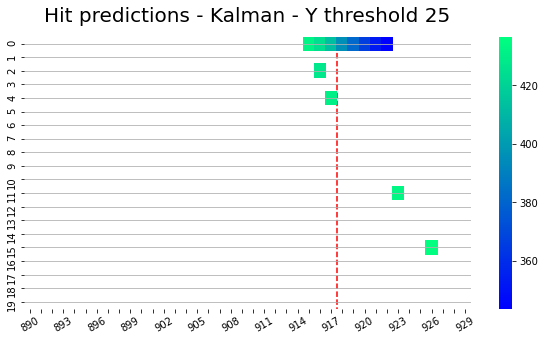

In [341]:
trial = 'fast_cockroach_20200803T085738_trial1'
forecasts = forecasts_dict_kalman[trial]

y_thrsh = 25

start = 890
end = 930
fs = 20
pad = 15

hit_preds = get_hit_preds_forecasts(forecasts_list=forecasts,
                                    hit_pred=hit_predictor,
                                    y_thresh=y_thrsh,
                                    return_mean=False)

#%matplotlib widget
%matplotlib inline
fig, ax1 = plt.subplots(1,1,figsize=(10,5))
plot_preds_and_truth(hit_preds,
                     all_df.loc[trial],
                     ax1,
                     start=start,
                     end=end)
plt.grid(axis='y')

s = f"Hit predictions - Kalman - Y threshold {y_thrsh}"
plt.title(s, fontsize=fs, pad=pad)
plt.savefig('../experiments_plots/'+trial+"_"+s+'.jpg', dpi=200)

In [408]:
forecast_preds = get_hit_preds_forecasts(forecasts_list=forecasts,
                                    hit_pred=hit_predictor,
                                    y_thresh=y_thrsh,
                                    preds_forecasts=False,
                                    return_mean=False)

Text(0.5, 1.0, 'Predictions of forecasts made at frame $k$ (x) to hit in $m$ timesteps (y)')

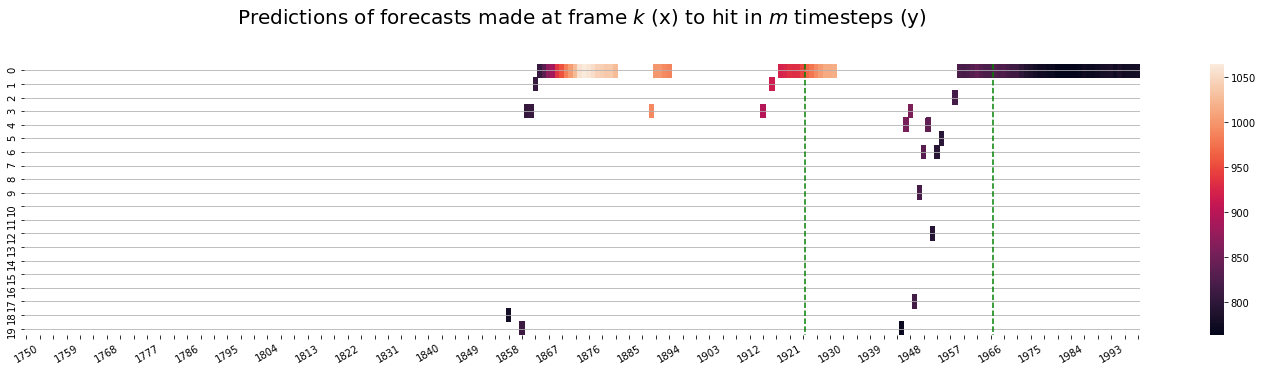

In [143]:
%matplotlib inline

fig, ax2 = plt.subplots(1,1,figsize=(25,5))
plot_preds_and_truth(forecast_preds,
                     all_df.loc[trial_data],
                     ax2,
                     start=start,
                     end=end)
plt.grid(axis='y')
plt.title("Predictions of forecasts made at frame $k$ (x) to hit in $m$ timesteps (y)", fontsize=fs, pad=pad)


## Visualize multiple trajectories

#### Training notes
Some general suggestions posts regarding training and generalization:
- https://stats.stackexchange.com/questions/352036/what-should-i-do-when-my-neural-network-doesnt-learn#

Most of the post deals with verifying the the correcteness of the data and the architecture. It doesn't seem that our network and\or data is malfunctioning.

- https://stats.stackexchange.com/questions/365778/what-should-i-do-when-my-neural-network-doesnt-generalize-well 

Dropout - in more layers 

Transfer learning from other movement dataset or even some language dataset? 

Data augmentation - take a smaller and more well chosen dataset, and expand it? maybe apply some linear transformations on the data, to both make the generalization better and have more data. Train a single model multiple times (or interchangingly) with diffrent input sequnce lengths - the weights don't change? filtering before training - applying an MA filter on the path will cause it to be less noisy, capturing the essential trend.

More regularization?

Early stopping - wev'e been doing it anyway, maybe make more concrete.

Generalization and metrics - what is a resonable validation/test error?  

#### __Ideas and observations from sequences plot:__
* Input-output length of 20 corresponds to 0.33 seconds. During fast movement, the animal can cover substential distance (in arena terms). Also, it's seems that 20 observations as input is way too much. if there's a trend in the input that seems somewhat predictive of the output, it will probably be in only the few last points. Moreover, some of the sequences of i20-o20, where X, Y or both are "long", i.e, "long" distance between first and last point, just seem "unlearnable". It's a relatively small portion of the entire dataset, but it seems that these are the sequences that matter most to the hit prediction. There's not alot to do with this other than state that this a hard problem to solve...
* A more practical question is this: what is the minimal time interval, where the course of an action (movement for example), can be changed by a decision? or in other words what is the maximal length of a path whose trajectory is controlled solely by mechanics and not decisions? it probably changes according to the type of action and it's initial velocity or accelaration. Reaction time and changing the course
* The feeding videos seems too dissimilar to the experiments data.
* The "sliding window artifcat"?

#### Directions:
- Data selection\filtering and augmentation (rotation). Maybe sequences with stride. Randomize loss length computation (until random K~U[1,out_seq_len]). The rationale - the errors from the distant timesteps, won't "hinder" the learning of short term movement.
- ADE as a function of input and output length.

In [351]:
# run only in initailization of notebook
trials_dict = train_eval.create_samples(df=all_df,
                                        mask_fn=mask_fn,
                                        keep_prob=mask_dict['keep_prob'],
                                        input_labels=net_params['input_labels'], output_labels=net_params['output_labels'], 
                                        input_seq_size=net_params['inp_seq_len'], output_seq_size=net_params['out_seq_len'],
                                        keep_nans=True)

/app/Pogona_realtime/Arena/Prediction/train_eval.py:665: RuntimeWarning: invalid value encountered in greater
  ret_mask = ret_mask & ((dists_X > min_dist) & (dists_X < max_dist))
/app/Pogona_realtime/Arena/Prediction/train_eval.py:665: RuntimeWarning: invalid value encountered in less
  ret_mask = ret_mask & ((dists_X > min_dist) & (dists_X < max_dist))
/app/Pogona_realtime/Arena/Prediction/train_eval.py:667: RuntimeWarning: invalid value encountered in greater
  ret_mask = ret_mask & ((dists_Y > min_dist) & (dists_Y < max_dist))
/app/Pogona_realtime/Arena/Prediction/train_eval.py:667: RuntimeWarning: invalid value encountered in less
  ret_mask = ret_mask & ((dists_Y > min_dist) & (dists_Y < max_dist))
/app/Pogona_realtime/Arena/Prediction/train_eval.py:686: RuntimeWarning: invalid value encountered in greater
  ret_mask = ret_mask & ((speeds_X > min_speed) & (speeds_X < max_speed))
/app/Pogona_realtime/Arena/Prediction/train_eval.py:686: RuntimeWarning: invalid value encountered in 

In [677]:
# run when masking is updated
train_eval.update_trials_dict(trials_dict, mask_fn, keep_prob=mask_dict['keep_prob'])

In [34]:
train_trials, val_trials, test_trials = train_eval.split_train_val_test(trials_dict, split=(1.0, 0, 0))

In [352]:
HP_JSON = 'Prediction/traj_models/models_params.json'

with open(HP_JSON, 'r') as fp:
    json_dict = json.load(fp)

model_parse = 'LSTMdense_1004-1753_i2_o20_h350_l1'
train_trials = json_dict[model_parse]['training_params']['train_trials']
val_trials = json_dict[model_parse]['training_params']['val_trials']
test_trials = json_dict[model_parse]['training_params']['test_trials']

In [353]:
batch_size = 128
train_dl, val_dl, test_dl = train_eval.create_train_val_test_dataloaders(trials_dict, train_trials, val_trials, test_trials,
                                                                         train_mask=False, val_mask=False, test_mask=False,
                                                                         batch_size=batch_size, shuffle=False)

print("Sample size:")
print(f"Training: {len(train_trials)} trials, {len(train_dl.dataset)} seqs")
if val_dl is not None:
    print(f"Validation: {len(val_trials)} trials, {len(val_dl.dataset)} seqs")
if test_dl is not None:
    print(f"Test: {len(test_trials)} trials, {len(test_dl.dataset)} seqs")

Sample size:
Training: 88 trials, 381108 seqs
Validation: 11 trials, 54082 seqs
Test: 11 trials, 44491 seqs


In [354]:
""" 
TODO - Sequence level prediction? create seq_data_Yhat - the same dimensions as seq_data_Y. 
How to batch predict? and only on the test set?
"""
def get_seq_forecast(dataloader, traj_pred):
    forecasts_list = []
    
    with torch.no_grad():
        for x, y in dataloader:
            y_hat = traj_pred.model(x.float().to(traj_pred.model.device)).cpu().numpy()
            forecasts_list.append(y_hat)
    return np.concatenate(forecasts_list)

In [355]:
dl = test_dl
seq_data_X = dl.dataset.X.numpy()#[:,:,2:]
seq_data_Y = dl.dataset.Y.numpy()#[:,:,2:]
seq_data_pred=None

In [356]:
print(f'Total MB of data: {seq_data_X.nbytes/2**20 + seq_data_Y.nbytes/2**20:.1f}')

Total MB of data: 27.2


In [357]:
seq_data_X.shape

(44491, 20, 4)

In [358]:
def eval_traj_predictor_on_trials(predictor, trials):
    all_results = []
    all_forecasts = []
    trial_lens = []
    
    for trial in trials:
        bboxes = all_df.loc[trial][['x1', 'y1', 'x2', 'y2']].values
        results, forecasts = train_eval.eval_trajectory_predictor(predictor, bboxes)
        all_results.append(results)
        all_forecasts.append(forecasts)
        trial_lens.append(bboxes.shape[0])
        
    ADEs = [r['avg ADE'] for r in all_results]
    FDEs = [r['avg FDE'] for r in all_results]
    
    return ADEs, FDEs, trial_lens, all_forecasts

def all_forecasts_to_seq_data(net_params, all_forecasts):
    all_np_forecasts = []
    inp_seq_len = net_params['inp_seq_len']
    out_seq_len = net_params['out_seq_len']
    out_dim = net_params['output_dim']
    nans_forecast = np.empty((out_seq_len, out_dim))
    nans_forecast[:] = np.nan

    for forecasts in all_forecasts:
        forecasts_wo_nones = [nans_forecast if f is None else f for f in forecasts]
        np_forecasts = np.stack(forecasts_wo_nones[inp_seq_len-1:-out_seq_len])
        all_np_forecasts.append(np_forecasts)
    
    return np.concatenate(all_np_forecasts)

In [175]:
ADEs, FDEs, trial_lens, all_forecasts = eval_traj_predictor_on_trials(traj_predictor_kalman, test_trials)
seq_data_pred_kalman = all_forecasts_to_seq_data(net_params, all_forecasts)

In [404]:
#seq_data_pred_lstm = get_seq_forecast(dl, traj_predictor_lstm)
seq_data_pred_gru = get_seq_forecast(dl, traj_predictor_gru)
#seq_data_pred = seq_data_pred[:,:,2:]

### Average ADE results on test set
- lstm: 9.8143/41.3148
- gru-20: 9.4457/40.2263
- gru-10: 6.4983/22.9242
- kalman 53.77565355787182 / 13.338808356545009


In [360]:
seq_data_pred_gru.shape, seq_data_pred_lstm.shape, seq_data_pred_kalman.shape

((44491, 20, 4), (44491, 20, 4), (44491, 20, 4))

In [129]:
bar_df = pd.DataFrame(index=['Enc-Linear', 'Enc-Dec-20-20', 'Kalman'], columns=['False','True'])

In [130]:
data = np.array([[ 9.8143,41.3148],
                [ 9.4457,40.2263],
                [13.338808356545009,53.77565355787182]])

In [131]:
bar_df.loc[:,:] = data

In [132]:
bar_df['Model'] = bar_df.index

In [133]:
long_df = pd.melt(bar_df,id_vars=['Model'], var_name='Masking',value_name='ADE', ignore_index=False)

In [134]:
long_df

,Model,Masking,ADE
Enc-Linear,Enc-Linear,False,9.814300
Enc-Dec-20-20,Enc-Dec-20-20,False,9.445700
Kalman,Kalman,False,13.338808
Enc-Linear,Enc-Linear,True,41.314800
Enc-Dec-20-20,Enc-Dec-20-20,True,40.226300
Kalman,Kalman,True,53.775654


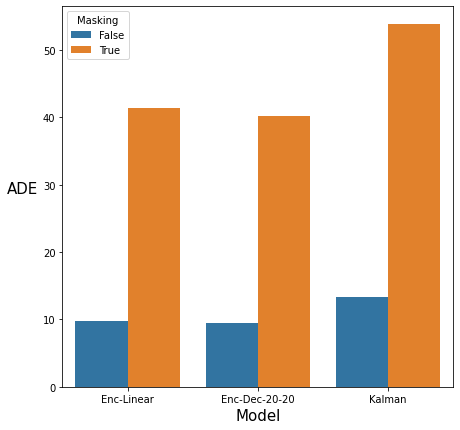

In [141]:
%matplotlib inline
plt.figure(figsize=(7,7))
sns.barplot(x='Model',y='ADE',hue='Masking',data=long_df)
plt.ylabel('ADE',fontsize=15, rotation=0,labelpad=20)
plt.xlabel('Model',fontsize=15)

plt.savefig('../experiments_plots/ADEs_bar.jpg',dpi=200)

In [54]:
train_eval.calc_ADE(torch.tensor(seq_data_pred[data_mask]), torch.tensor(seq_data_Y[data_mask]))

tensor(22.9242)

In [27]:
seq_data_Y.shape

(44395, 20, 2)

In [230]:
hits_X, hits_Y = seqs_contain_hits(all_df.loc[test_trials], 20, 20, steps2hit=0, stride=1)

In [683]:
hits_preds = get_seq_forecast(train_eval.DataLoader(train_eval.TrajectoriesData(hits_X, hits_Y),batch_size=128), traj_predictor)

In [21]:
im = cv.imread('../pogona_frames/transformed_image.jpg')
im = cv.convertScaleAbs(im, alpha=2.5,beta=-128)

#### Visualizer

In [423]:
%matplotlib widget
#%matplotlib inline
fig,ax = plt.subplots(1,1,figsize=(7,9))

ax.imshow(im,alpha=0.15)

N_samples = 2

data_mask = mask_fn(seq_data_X, seq_data_Y)

sampling_mask = np.random.choice(np.argwhere(data_mask).squeeze(), size=N_samples)

sample_X = seq_data_X[sampling_mask]
sample_Y = seq_data_Y[sampling_mask]

sample_kalman = seq_data_pred_kalman[sampling_mask]
sample_lstm = seq_data_pred_lstm[sampling_mask]
sample_gru = seq_data_pred_gru[sampling_mask]

if seq_data_pred is not None:
    sample_pred = seq_data_pred[sampling_mask]
    draw_diffs = True
else:
    sample_pred = None
    draw_diffs = False
"""
sampling_mask = np.random.choice(np.arange(hits_X.shape[0]),size=N_samples)
sample_X = hits_X[:,:,2:][sampling_mask]
sample_Y = hits_Y[:,:,2:][sampling_mask]
#sample_pred = hits_preds[:,:,2:][sampling_mask]

touches = (all_df.is_touch) #& (all_df.y2 > 250)
plt.scatter(all_df[touches].x2, all_df[touches].y2, color='y', s=25)
"""

l_alpha = 0.5

draw_sequences(arr_X=sample_X,
           arr_Y=sample_Y,
           arr_pred=None,
           ax=ax,
           sctr_s=1,
           l_alpha=l_alpha,
           sctr_alpha=0.75,
           to_scatter=True,
           draw_diffs=False)


draw_sequences(arr_X=None,
           arr_Y=sample_kalman,
           arr_pred=None,
           ax=ax,
           sctr_s=1,
           l_alpha=l_alpha,
           sctr_alpha=0.75,
           to_scatter=True,
           draw_diffs=False,
           ylabel='Kalman',
              ftr_c='c')

"""
draw_sequences(arr_X=None,
           arr_Y=sample_lstm,
           arr_pred=None,
           ax=ax,
           sctr_s=1,
           l_alpha=0.2,
           sctr_alpha=0.75,
           to_scatter=True,
           draw_diffs=False,
           ylabel='Enc-Linear',
              ftr_c='magenta')
"""
draw_sequences(arr_X=None,
           arr_Y=sample_gru,
           arr_pred=None,
           ax=ax,
           sctr_s=1,
           l_alpha=l_alpha,
           sctr_alpha=0.75,
           to_scatter=True,
           draw_diffs=False,
           ylabel='Enc-Dec',
              ftr_c='orange')


#draw_lines(data_X,data_Y)

#ax.autoscale() # why doesn't work without this?
#ax.axis('equal')
#txt_color = 'white'
ax.set_title(f'Input: {net_params["inp_seq_len"]}, Output: {net_params["out_seq_len"]} || {data_mask.sum():,} sequences',fontsize=13)
fig.set_facecolor(color='w')
ax.legend()

#plt.savefig("../experiments_plots/sequence_sample.png", dpi=200)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [414]:
test_trials

['learning_20200917T152238_trial1',
 'learning_20200917T152238_trial3',
 'fast_cockroach_20200803T085738_trial1',
 'learning_20201001T081837_trial3',
 'learning_20201001T081837_trial5',
 'learning_20200917T154539_trial3',
 'worm_circle_20200830T122241_trial1',
 'beetle_fast_line_20200830T124020_trial1',
 'circle_20200803T093051_trial1',
 'line_20200803T095401_trial1',
 'learning_20200923T111426_trial3']

In [126]:
def calc_mean_DE(y, y_hat):
    """
    Calculate the  average displacement error (DE) of a test set of predictions
    displacement is the L2 norm between the prediction and the truth
    :param y_hat: torch tensor dims (number of sample, out seq size, out size)
    :param y: same
    :return: average DE for each timestep over batch
    """
    if len(y_hat.shape) == 2:
        y_hat = y_hat[None,:,:]
        y = y[None,:,:]

    return np.mean(np.linalg.norm(y_hat - y, axis=2), axis=0)


def calc_DE(y, y_hat):
    """
    Calculate the  average displacement error (DE) of a test set of predictions
    displacement is the L2 norm between the prediction and the truth
    :param y_hat: torch tensor dims (number of sample, out seq size, out size)
    :param y: same
    :return: average DE for each timestep over batch
    """
    if len(y_hat.shape) == 2:
        y_hat = y_hat[None,:,:]
        y = y[None,:,:]

    return np.linalg.norm(y_hat - y, axis=2)




In [127]:
des = calc_mean_DE(seq_data_Y, seq_data_pred)

AttributeError: 'NoneType' object has no attribute 'shape'

In [657]:
des_dists = calc_DE(seq_data_Y[data_mask], seq_data_pred[data_mask])

In [658]:
de_df = pd.DataFrame(data=des_dists, columns=np.arange(1,21))

Text(0.5, 1.0, 'Displacement error distribution as a function of timestep')

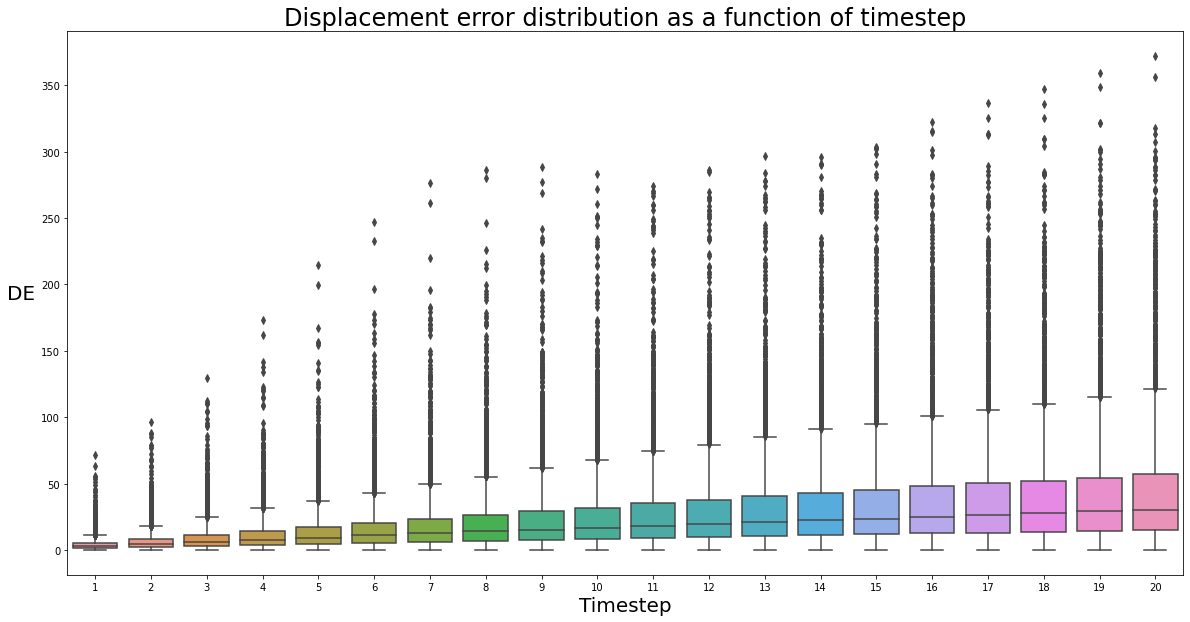

In [667]:
%matplotlib inline
fig, ax = plt.subplots(1,1,figsize=(20,10))
sns.boxplot(data=de_df,ax=ax)
ax.set_xlabel('Timestep', fontsize=20)
ax.set_ylabel('DE', fontsize=20,rotation=0,labelpad=20)
ax.set_title('Displacement error distribution as a function of timestep',fontsize=24)

In [651]:
de_df.shape

(83, 20)

Pearson's r: 0.9976742715, p-val: 0.0000000000


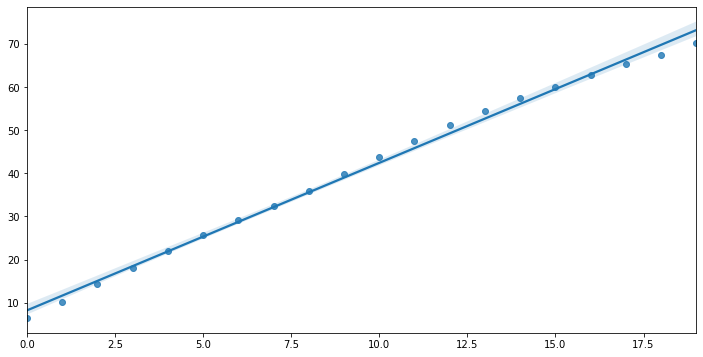

In [650]:
%matplotlib inline
plt.figure(figsize=(12,6))
x = np.arange(len(de_df.columns))
des = de_df.mean(axis=0)
sns.regplot(x, de_df.mean(axis=0))
#plt.axis('equal')

pear = pearsonr(x, des)
print(f"Pearson's r: {pear[0]:.10f}, p-val: {pear[1]:.10f}")

In [13]:
touches = all_df.is_touch

In [15]:
all_df.head()

,cent_x,cent_y,x1,y1,x2,y2,conf,num_bbox,frame_ts,hit_x,hit_y,bug_x,bug_y,is_hit,touch_ts,is_touch
feeding_20200830-115520_None,1465.396287,3215.457874,1636.567468,3431.274696,1306.914523,3018.390327,0.986670,1.0,2020-08-30 08:55:20.382360458,NaN,NaN,NaN,NaN,NaN,NaT,False
feeding_20200830-115520_None,1456.438238,3218.703607,1633.532734,3428.864720,1292.171817,3026.739644,0.991233,1.0,2020-08-30 08:55:20.399383068,NaN,NaN,NaN,NaN,NaN,NaT,False
feeding_20200830-115520_None,1455.864165,3218.964280,1632.594184,3428.486032,1291.898023,3027.539691,0.992867,1.0,2020-08-30 08:55:20.416419268,NaN,NaN,NaN,NaN,NaN,NaT,False
feeding_20200830-115520_None,1456.556067,3219.311814,1634.249838,3429.889285,1291.759208,3027.011880,0.992325,1.0,2020-08-30 08:55:20.433441877,NaN,NaN,NaN,NaN,NaN,NaT,False
feeding_20200830-115520_None,1457.322849,3218.377523,1634.933286,3427.408600,1292.527316,3027.413619,0.992355,1.0,2020-08-30 08:55:20.450448990,NaN,NaN,NaN,NaN,NaN,NaT,False


In [57]:
for ts in all_df.loc[trial].touch_ts[::-1]:
    print(type(ts))
    break

<class 'pandas._libs.tslibs.timestamps.Timestamp'>


In [69]:
pd.Timedelta(-3.0, unit='h')

Timedelta('-1 days +21:00:00')

In [111]:
for trial in all_df[touches].index.unique():
    
    max_touch_ts = all_df.loc[trial].touch_ts.max()
    max_diff_hr = np.min((all_df.loc[trial].frame_ts - max_touch_ts).dt.total_seconds()/60/60)
    hr_diff = np.round(max_diff_hr)
    #min_frame_ts = all_df.loc[trial].frame_ts.min()
    print(f"trial: {trial}, hr diff round: {np.round(max_diff_hr)}")
    if np.abs(hr_diff) >= 1:
        print(f"trial: {trial}, hr diff round: {np.round(max_diff_hr)}")
    
        for touch_ts in all_df.loc[trial].touch_ts:
            if not pd.isna(touch_ts):
                hr_delta = pd.Timedelta(hr_diff, unit='h')
                if hr_diff < 0:
                    corr_touch = touch_ts + hr_delta
                else:
                    corr_touch = touch_ts - hr_delta
                real_min_diff = np.min((corr_touch - all_df.loc[trial].frame_ts).dt.total_seconds()/60/60)
                print(f"real diff for touch: {real_min_diff}")
    
    #print(f"{trial}: diff: {diff}")

trial: line_20200803T081429_trial1, hr diff round: -0.0
trial: fast_line_20200803T082414_trial1, hr diff round: -0.0
trial: fast_line_20200803T082724_trial1, hr diff round: -0.0
trial: fast_cockroach_20200803T085738_trial1, hr diff round: -0.0
trial: circle_20200803T090234_trial1, hr diff round: -0.0
trial: circle_20200803T091639_trial1, hr diff round: -0.0
trial: circle_20200803T092248_trial1, hr diff round: -0.0
trial: line_20200803T114942_trial1, hr diff round: -0.0
trial: circle_20200803T115839_trial1, hr diff round: -0.0
trial: circle_20200803T120911_trial1, hr diff round: -0.0
trial: red_beetle_20200826T133947_trial1, hr diff round: -0.0
trial: worm_20200826T134603_trial1, hr diff round: -0.0
trial: worm_20200826T135440_trial1, hr diff round: -0.0
trial: worm_20200826T135440_trial2, hr diff round: -0.0
trial: worm_line_20200830T121825_trial1, hr diff round: -0.0
trial: worm_circle_20200830T122241_trial1, hr diff round: -0.0
trial: learning_20200917T081521_trial2, hr diff round: -

In [125]:
all_df[all_df.is_hit.isna()].index.unique()

Index(['feeding_20200830-115520_None', 'feeding_20200830-120813_None',
       'feeding_4_20200830-121143_None', 'feeding_4_20200830-122515_None',
       'feeding_4_20200830-125531_None', 'feeding_4_20200830-125905_None',
       'feeding_4_screen_20200830-130446_None',
       'feeding_5_20200830-131348_None', 'line_20200803T081429_trial1',
       'line_20200803T081735_trial1',
       ...
       'learning_20201001T085812_trial3', 'learning_20201001T085812_trial4',
       'learning_20201001T085812_trial5', 'learning_20201001T085812_trial6',
       'learning_20201001T100451_trial1', 'learning_20201001T100451_trial2',
       'learning_20201001T100451_trial3', 'learning_20201001T100451_trial4',
       'learning_20201001T100451_trial5', 'learning_20201001T100451_trial6'],
      dtype='object', length=110)

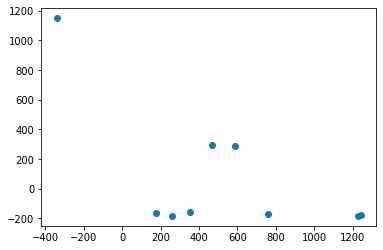

In [156]:
m = all_df.is_touch & all_df.is_hit & (np.abs(all_df.y2) > 150)
plt.scatter(all_df[m].x2, all_df[m].y2)

In [158]:
all_df[m].index.unique()

Index(['fast_line_20200803T082414_trial1', 'red_beetle_20200826T133947_trial1',
       'worm_20200826T135440_trial1', 'worm_20200826T135440_trial2',
       'worm_line_20200830T121825_trial1',
       'worm_circle_20200830T122241_trial1', 'learning_20200917T154539_trial2',
       'learning_20200917T154539_trial3'],
      dtype='object')

In [148]:
all_df[m][(all_df[m].frame_ts - all_df[m].touch_ts).dt.total_seconds().abs() > 1]


,cent_x,cent_y,x1,y1,x2,y2,conf,num_bbox,frame_ts,hit_x,hit_y,bug_x,bug_y,is_hit,touch_ts,is_touch
learning_20200917T084025_trial1,157.506846,157.912515,263.876716,307.618018,48.113721,3.709467,0.981272,1.0,2020-09-17 08:40:44.539921045,132.0,585.0,128.0,609.0,True,2020-09-17 08:40:46.576156,True
learning_20200917T084025_trial2,1370.862116,141.451001,1494.377508,269.919678,1250.456141,11.858054,0.985266,1.0,2020-09-17 08:47:58.547316313,1351.0,579.0,1355.0,581.0,True,2020-09-17 08:48:00.576039,True
learning_20200917T150415_trial3,718.607859,219.056084,841.079633,360.266782,595.932435,75.085390,0.993237,1.0,2020-09-17 15:17:49.252039194,981.0,146.0,968.0,166.0,True,2020-09-17 15:17:51.282377,True
learning_20200917T152238_trial1,1422.422500,198.078546,1546.095343,373.313708,1303.232575,22.101105,0.991156,1.0,2020-09-17 15:22:44.916004181,1231.0,353.0,1219.0,364.0,True,2020-09-17 15:22:46.950596,True
learning_20200917T152238_trial2,1892.335373,145.131844,2010.284835,292.634537,1780.227821,-2.083330,0.992708,1.0,2020-09-17 15:27:49.546883583,1749.0,603.0,1815.0,700.0,True,2020-09-17 15:27:51.582562,True
learning_20200917T154539_trial2,581.613184,428.265112,694.900696,560.957350,468.022267,294.036938,0.993373,1.0,2020-09-17 15:53:33.419976950,1423.0,290.0,1440.0,282.0,True,2020-09-17 15:53:35.458143,True
learning_20200917T154539_trial3,718.212706,408.419232,847.936870,527.660556,588.637764,287.565422,0.993363,1.0,2020-09-17 15:59:27.100150585,1003.0,33.0,1042.0,26.0,True,2020-09-17 15:59:29.117933,True
learning_20201001T081837_trial1,1449.736373,116.034523,1568.492041,260.973320,1334.546844,-30.014989,0.988978,1.0,2020-10-01 08:19:16.169486284,1642.0,491.0,1658.0,457.0,True,2020-10-01 08:19:18.203604,True
learning_20201001T084647_trial1,-45.495505,85.993298,86.709724,217.194621,-183.139383,-51.297857,0.995607,1.0,2020-10-01 08:47:03.844775438,74.0,332.0,57.0,292.0,True,2020-10-01 08:47:05.880701,True
learning_20201001T084647_trial2,782.214429,110.781022,909.491116,234.824354,654.695503,-16.327083,0.993623,1.0,2020-10-01 08:52:09.348243952,974.0,82.0,1021.0,-23.0,True,2020-10-01 08:52:11.374072,True


In [ ]:
for trial in all_df.index.unique():
    for name in ['learning','baby']:
        if name in trial:
            print(all_df.loc[trial].shape)
            display(all_df.loc[trial].tail(3))

Hi regev,
We found a possible bug in the "Learning" experimental paradigm, where the video stops upon touching of the screen. It appears that in some of the trials, the program has written a touch of the screen in the last frame, while the animal wasn't moving.
Here are some trials that the bounding box that was recorded in the last frame (where the touch was recorded) is far away from the screen and appears to be not moving in the frames before: 

-learning_20201001T081837, trial4
-baby_initial_20200923T135525, trial2
-

### Various statistics and distributions


TODO:
- distances - between first and last points, others. Notice that there are some paths that are circular, meaning that they traverse some distance but the first and last are relatively close.
- velocities - mean velocity in X and Y
- linearity (?) - how much a sequence lies on a straight line? - Pearson's r, or linear regression model. Curvture - how much the path is curved or zigzagging? angle between to consecutive lines in path.


In [71]:
def plot_distribution(ax, 
                   data_array,
                   label,
                   min_thresh=None, max_thresh=None,
                   title=None,
                   kde=True, bins=500, color='b'):
    
    mask = np.array([True] * data_array.shape[0])
    if min_thresh:
        min_mask = data_array > min_thresh
        mask = mask & min_mask
    if max_thresh:
        max_mask = data_array < max_thresh
        mask = mask & max_mask     
        
    sns.distplot(data_array[mask], label=label, kde=kde, bins=bins,ax=ax, color=color)
    ax.set_ylabel(label, fontsize=14, labelpad=20, rotation=45)
    #ax.legend()
    if title:
        ax.set_title(title)


In [73]:
#funcs = [train_eval.compute_dists, train_eval.compute_speeds, train_eval.compute_zigzagity, train_eval.compute_batch_r]
funcs = [train_eval.compute_speeds, train_eval.compute_zigzagity, train_eval.compute_batch_r]

#labels = ['distance', 'speed','zigzagity', 'pear_r']
labels = ['speed','zigzagity', 'pear_r']

distr_X_full = {key:pd.Series(func(seq_data_X),name=key) for key,func in zip(labels, funcs)}

/app/Pogona_realtime/Arena/Prediction/train_eval.py:704: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(dotprods / (u_norm * v_norm))


In [102]:
funcs = [train_eval.compute_dists, train_eval.compute_speeds, train_eval.compute_zigzagity, train_eval.compute_batch_r]
labels = ['distance', 'speed','zigzagity', 'pear_r']
distr_X_hits = {key:pd.Series(func(hits_X[:,:,2:]),name=key) for key,func in zip(labels, funcs)}

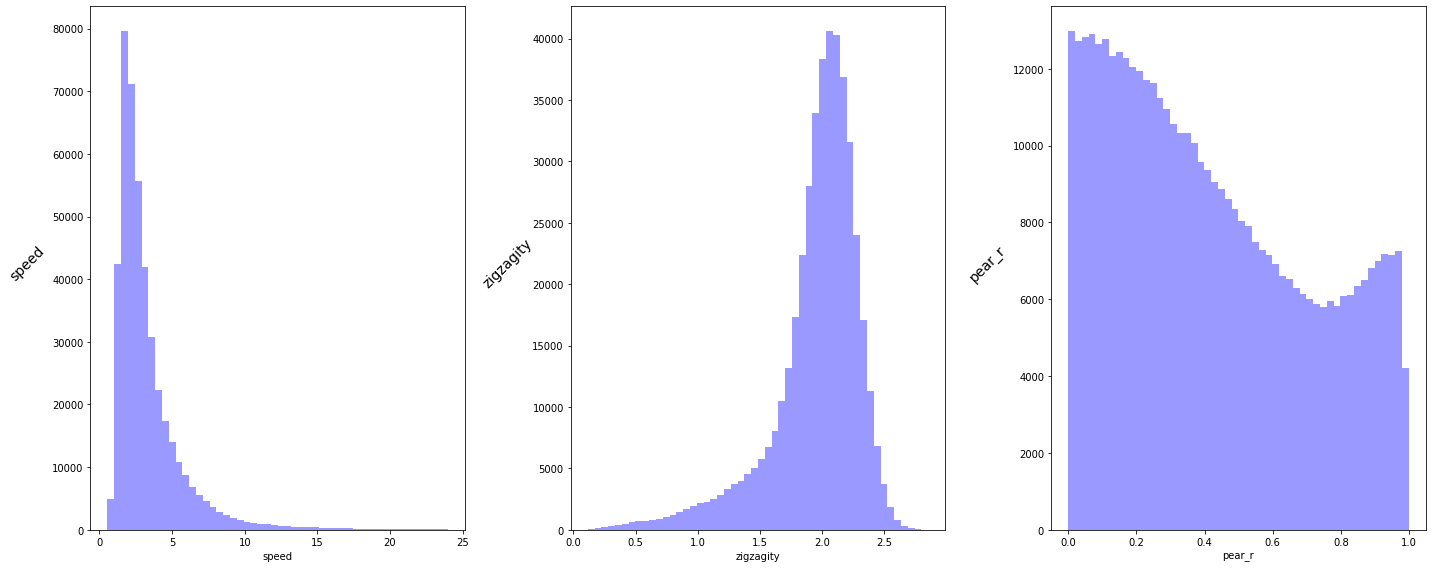

In [82]:
%matplotlib inline
fig, axes = plt.subplots(1, len(funcs), figsize=(20,8))
for ax, label in zip(axes, labels):
    max_thresh = 24
    plot_distribution(ax, 
                      distr_X_full[label], 
                      label=label,
                      kde=False,
                      bins=50, max_thresh=max_thresh)
    """
    plot_distribution(ax, 
                      distr_X_full[label], 
                      label=None,
                      kde=True,
                      bins=50, color='r',max_thresh=max_thresh)
    """
#fig.suptitle('Data statitstics', fontsize=20)
fig.tight_layout()
fig.savefig('../experiments_plots/data_stats.jpg')


In [61]:
distr_X_full['zigzagity'].quantile([0.01,0.05, 0.1, 0.25, .5, .75 ,.9])

0.01    0.661183
0.05    1.205997
0.10    1.499100
0.25    1.830956
0.50    2.025844
0.75    2.178129
0.90    2.302323
Name: zigzagity, dtype: float32

In [189]:
data_mask.sum()

3897

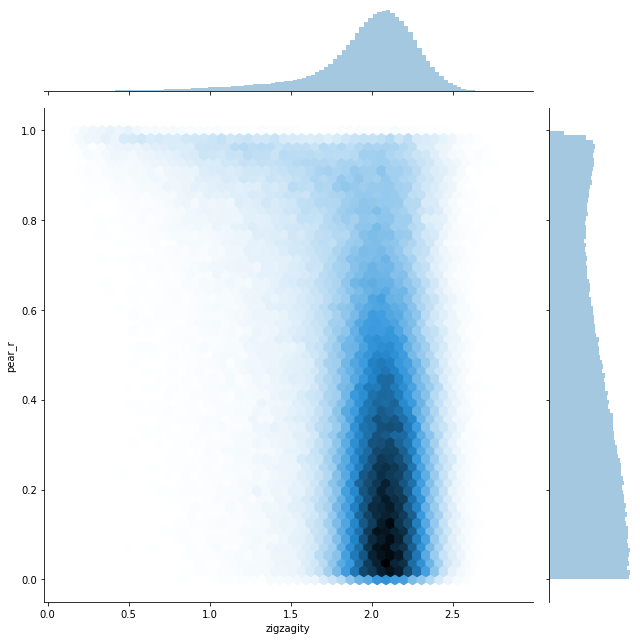

In [88]:
%matplotlib inline
# plot 2d relationship
x_axis = 'zigzagity'
y_axis = 'pear_r'
alpha = 1
color='r'

#plt.figure()
#fig, ax = plt.subplots(1,1,figsize=(12,6))
#sns.scatterplot(distr_X_full[x_axis], distr_X_full[y_axis], ax=ax, alpha=alpha,color=color)
g = sns.jointplot(distr_X_full[x_axis], distr_X_full[y_axis], kind='hex',alpha=alpha,marginal_kws={'bins':100}, height=9)
#fig.set_facecolor('w')
g.savefig('../experiments_plots/zgzg_r_data.jpg')

### Displacement Error for each timestep

In [ ]:
def calc_DE(y_hat, y):
    """
    Calculate the average displacement error (DE) of a test set of predictions
    displacement is the L2 norm between the prediction and the truth
    :param y_hat: torch tensor dims (number of sample, out seq size, out size)
    :param y: same
    :return: mean DE for each timestep
    """
    if len(y_hat.shape) == 2:
        y_hat = y_hat.unsqueeze(0)
        y = y.unsqueeze(0)

    return torch.mean(torch.norm(y_hat - y, dim=2), dim=1).mean()

#### TODO: Stats for detections data itself - 
- location clustering, speed from last detection, variability of a single trial (not of sequences?)

In [100]:
group_df = all_df.groupby(by=all_df.index).std().sort_values(by='x2',ascending=False)
group_df

,cent_x,cent_y,x1,y1,x2,y2,conf,num_bbox,hit_x,hit_y,bug_x,bug_y,is_touch
feeding_4_screen_20200830-130446_None,466.326476,284.764055,477.684566,286.222591,458.165240,286.106747,0.010892,0.0,NaN,NaN,NaN,NaN,0.000000
worm_circle_20200830T122241_trial1,442.794207,100.935395,438.731274,103.975594,449.767305,98.601986,0.001731,0.0,NaN,NaN,NaN,NaN,0.013752
worm_20200826T134603_trial1,401.296846,72.468718,403.056616,72.505333,401.962319,75.634243,0.002518,0.0,NaN,NaN,NaN,NaN,0.013748
fast_cockroach_20200803T085738_trial1,364.344155,68.012260,367.963365,66.689621,363.788717,72.244631,0.001809,0.0,326.131415,306.077278,329.368638,393.399670,0.031357
feeding_20200830-120813_None,345.372409,394.883780,348.232308,395.978931,344.730780,396.130092,0.011785,0.0,NaN,NaN,NaN,NaN,0.000000
line_20200803T094928_trial1,336.012303,55.631021,339.274200,55.006471,336.040682,58.201248,0.002642,0.0,NaN,NaN,NaN,NaN,0.000000
circle_20200803T120911_trial1,277.232780,87.658076,282.904299,86.994005,273.175380,90.118257,0.011761,0.0,289.206674,291.327994,344.053603,269.223544,0.019838
feeding_4_20200830-125531_None,269.381826,613.742164,275.769973,616.451649,265.228558,614.775252,0.004917,0.0,NaN,NaN,NaN,NaN,0.000000
fast_line_20200803T082414_trial1,242.832072,167.025083,239.489555,165.502539,247.458228,169.662876,0.001743,0.0,865.498700,54.447222,100.409163,224.859956,0.019838
worm_20200826T135440_trial1,235.102901,316.688909,239.228814,322.132830,233.615259,313.680865,0.006717,0.0,NaN,NaN,NaN,NaN,0.013753


No handles with labels found to put in legend.


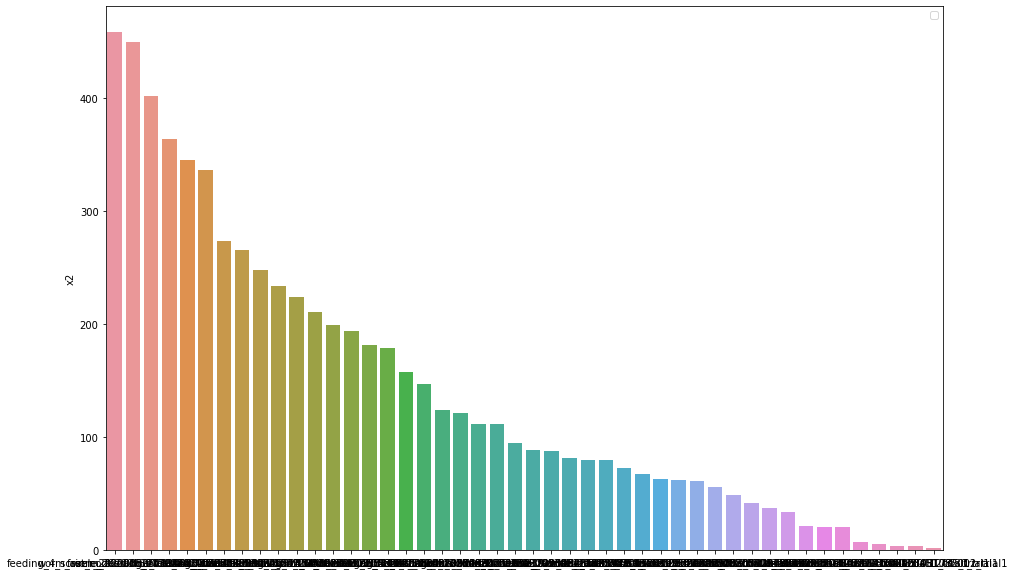

In [115]:
plt.figure(figsize=(15,10))
sns.barplot(x=group_df.index,y='x2',data=group_df)
plt.legend()

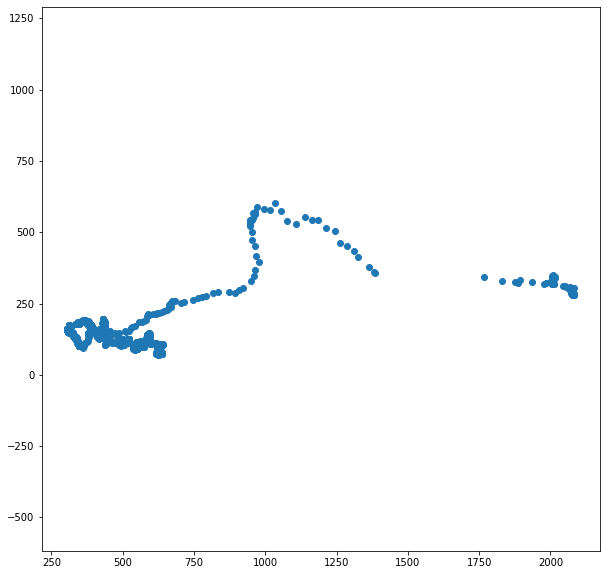

In [127]:
plt.figure(figsize=(10,10))
plt.axis('equal')
plt.scatter(all_df.loc['line_20200803T094928_trial1','x2'], all_df.loc['line_20200803T094928_trial1','y2'])

In [383]:
np.array([1,2,3])[:,np.newaxis] * np.random.random(size=(3,4))

array([[0.18452017, 0.39214223, 0.652962  , 0.97055323],
       [1.82708117, 0.99595282, 1.94592943, 1.76465548],
       [0.07270727, 2.06994075, 2.11620262, 0.32464095]])

In [432]:
np.array([1,1,1]).reshape(1,-1,1)

array([[[1],
        [1],
        [1]]])

In [429]:
np.concatenate([np.concatenate([seq_data_X[:2], seq_data_Y[:2]], axis=1), np.array([1]).reshape(1,1,1)], axis=2)

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 2 and the array at index 1 has size 1

In [444]:
np.concatenate([test_X[-1].reshape(-1,2), test_Y[0].reshape(-1,2)],axis=0).mean(axis=0)

array([ 751.5834, 1660.6426], dtype=float32)

In [446]:
test_X, test_Y = seq_data_X[0], seq_data_Y[0]
mid_point = np.concatenate([test_X[-1].reshape(-1,2), test_Y[0].reshape(-1,2)],axis=0).mean(axis=0)

In [447]:
seq_rot = cv.getRotationMatrix2D(tuple(mid_point),90,1)

In [448]:
seq_rot gru

array([[ 6.12323400e-17,  1.00000000e+00, -9.09059204e+02],
       [-1.00000000e+00,  6.12323400e-17,  2.41222595e+03]])

In [477]:
def rotate_seq(seq, rot_mat):
    padded = np.concatenate([seq, np.ones(seq.shape[0]).reshape(-1,1)], axis=1)
    return np.dot(padded, rot_mat.T)

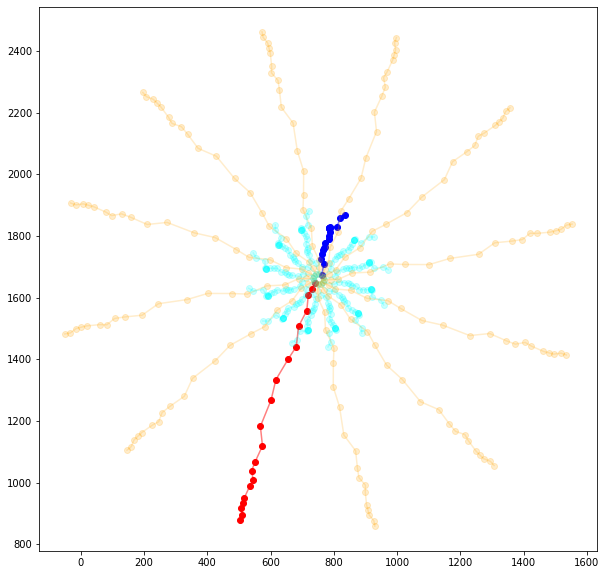

In [450]:
%matplotlib inline
plt.figure(figsize=(10,10))
plt.scatter(test_X[:,0],test_X[:,1],color='b')
plt.plot(test_X[:,0],test_X[:,1],color='b',alpha=0.5)

plt.scatter(test_Y[:,0],test_Y[:,1],color='r')
plt.plot(test_Y[:,0],test_Y[:,1],color='r',alpha=0.5)

for angle in range(30,360,30):
    mat= cv.getRotationMatrix2D(tuple(mid_point),angle,1)
    rot_test_X = rotate_seq(test_X, mat)
    rot_text_Y = rotate_seq(test_Y, mat)
    
    alpha2 = 0.2
    plt.scatter(rot_test_X[:,0],rot_test_X[:,1],color='cyan',alpha=alpha2)
    plt.plot(rot_test_X[:,0],rot_test_X[:,1],color='cyan',alpha=alpha2)

    plt.scatter(rot_text_Y[:,0],rot_text_Y[:,1],color='orange',alpha=alpha2)
    plt.plot(rot_text_Y[:,0],rot_text_Y[:,1],color='orange',alpha=alpha2)


### Evaluate trajectory predictor on a list of trials

In [457]:
HP_JSON = 'Prediction/traj_models/models_params.json'

with open(HP_JSON, 'r') as fp:
    json_dict = json.load(fp)

trials = json_dict['GRUEncDec_0930-2136_i20_o20_h350_l1']['training_params']['val_trials']

In [475]:
results = []
for trial in trials:
    bboxes = all_df.loc[trial][['x1','y1','x2','y2']].values
    trial_results, _ = train_eval.eval_trajectory_predictor(traj_predictor, bboxes)
    results.append(trial_results)
    
print(results[0])


{'avg ADE': 32.48123662683412, 'avg FDE': 56.39232147871813, 'avg time (ms)': 2.6288210372008853}


In [476]:
ADEs = [r['avg ADE'] for r in results]
print(np.array(ADEs).mean())

15.509666080208724


In [ ]:
21.966887520086793